## **RTM-FASS MAIN CODE**

Welcome to RTM-FASS

**If you would like to just analyse a fight:**

Please run any code cell with a "⭐"

**If you want to run everything and reprocess data and retrain model**

Run EVERY single cell in order


#Force mount Gdrive and install libraries **(RESTART RUNTIME AS SOON AS THIS HAS FINISHED OTHERWISE YOU WILL GET A NUMPY ISSUE)** ⭐

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q ultralytics==8.0.145 opencv-python pandas numpy==1.24.3 matplotlib tqdm yt-dlp torch==2.0.1 torchvision==0.15.2 pycocotools gradio
!pip install pycocotools


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.9 MB/s eta

# Import all libraries needed and creates and sets all directories used, checks for CUDA too ⭐

In [23]:
import os
import sys
import zipfile
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import time
import json
from pathlib import Path
from IPython.display import HTML, Image, display
from ultralytics import YOLO
from pycocotools.coco import COCO
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import files


PROJECT_PATH = "/content/drive/MyDrive/RTM-FASS"
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

DATA_DIRECTORY = f"{PROJECT_PATH}/data"
OUTPUT_DIRECTORY = f"{PROJECT_PATH}/data/strike_dataset"
MODEL_DIRECTORY = f"{PROJECT_PATH}/models"
RAW_DIRECTORY = f"{PROJECT_PATH}/data/raw_videos"

for directory_path in [DATA_DIRECTORY, OUTPUT_DIRECTORY, MODEL_DIRECTORY, RAW_DIRECTORY]:
    os.makedirs(directory_path, exist_ok=True)


if torch.cuda.is_available():  #just to make sure the oom error doesnt happen for some reason
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"Using GPU: {torch.cuda.get_device_name()}")
    print(f"Memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU")




Using GPU: NVIDIA A100-SXM4-40GB
Memory available: 42.5 GB


# Initialise all other files in project ⭐

In [2]:
from src.pose_detector import PoseDetector
from src.data_processor import StrikeDataProcessor, get_dataloaders
from src.strike_model import StrikeNet
from src.strike_detector import StrikeDetector
from src.fight_analyzer import FightAnalyzer
from src.visualization import FightVisualizer

#Process padwork dataset (WARNING TAKES QUITE LONG)




In [22]:
def process_strike_dataset(csv_file_path=None, video_directory=None, output_directory=None, sequence_length=15):
    print("\n=== PROCESSING MUAY THAI STRIKE DATASET ===")

    if output_directory is None:
        output_directory = OUTPUT_DIRECTORY

    os.makedirs(output_directory, exist_ok=True)

    if csv_file_path is None:
        csv_file_path = f"{PROJECT_PATH}/data/techniques_dataset.csv"
        print(f"Using dataset: {csv_file_path}")

    if video_directory is None:
        video_directory = f"{PROJECT_PATH}/data/raw_videos/strikes"
        print(f"Using video directory: {video_directory}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    pose_model = YOLO("yolov8x-pose.pt")

    if os.path.exists(csv_file_path):
        annotations = pd.read_csv(csv_file_path)
        print(f"Found {len(annotations)} annotations")
        print(f"Labels: {annotations['label'].value_counts().to_dict()}")
    else:
        print(f"Error: CSV file not found at {csv_file_path}")
        return None

    sequences_data = []

    for index, row in tqdm(annotations.iterrows(), total=len(annotations), desc="Processing videos"):
        try:
            label = row['label']
            video_path = row['out']

            if not os.path.exists(video_path):
                print(f"Warning: Video not found {video_path}, skipping...")
                continue

            fighter_id = int(row['fighter_id']) if 'fighter_id' in row and not pd.isna(row['fighter_id']) else 0
            outcome = row['outcome'] if 'outcome' in row and not pd.isna(row['outcome']) else 'successful'

            video_capture = cv2.VideoCapture(video_path)
            if not video_capture.isOpened():
                print(f"Warning: Could not open {video_path}, skipping...")
                continue

            frames_per_second = video_capture.get(cv2.CAP_PROP_FPS)
            total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

            if total_frames < 90:
                start_frame = 0
                end_frame = total_frames
            else:
                middle_frame = total_frames // 2
                start_frame = max(0, middle_frame - 45)
                end_frame = min(total_frames, middle_frame + 45)

            video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            frames = []
            desired_frames = min(30, end_frame - start_frame)
            frame_indices = np.linspace(start_frame, end_frame - 1, desired_frames, dtype=int)

            for frame_index in frame_indices:
                video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                return_value, frame = video_capture.read()
                if return_value:
                    frames.append((frame_index, frame))

            video_capture.release()

            if not frames:
                print(f"Could not extract frames from {video_path}")
                continue

            keypoints_sequence = []
            for frame_index, frame in frames:
                results = pose_model(frame, conf=0.25, verbose=False)

                if hasattr(results[0], 'keypoints') and results[0].keypoints is not None:
                    keypoints_data = results[0].keypoints.data
                    if len(keypoints_data) > 0:
                        keypoints = keypoints_data[0].cpu().numpy()
                        keypoints_sequence.append(keypoints)

            if len(keypoints_sequence) == 0:
                print(f"No keypoints detected in {video_path} - skipping")
                continue

            if len(keypoints_sequence) < sequence_length:
                while len(keypoints_sequence) < sequence_length:
                    keypoints_sequence.append(keypoints_sequence[-1] if keypoints_sequence else np.zeros((17, 3)))
            elif len(keypoints_sequence) > sequence_length:
                indices = np.linspace(0, len(keypoints_sequence) - 1, sequence_length, dtype=int)
                keypoints_sequence = [keypoints_sequence[i] for i in indices]

            video_name = Path(video_path).stem
            sequence_id = f"{label}_{video_name}_{fighter_id}"
            sequence_path = f"{output_directory}/{sequence_id}.npy"
            np.save(sequence_path, np.array(keypoints_sequence))

            sequences_data.append({
                'id': sequence_id,
                'label': label,
                'path': sequence_path,
                'video_path': video_path,
                'fighter_id': fighter_id,
                'outcome': outcome,
                'frames': len(keypoints_sequence)
            })

        except Exception as e:
            print(f"Error processing {row['out']}: {str(e)}")
            continue

    if sequences_data:
        metadata_dataframe = pd.DataFrame(sequences_data)
        metadata_path = f"{output_directory}/strike_sequences.csv"
        metadata_dataframe.to_csv(metadata_path, index=False)

        print(f"\nDataset processed successfully:")
        print(f"- Total sequences: {len(sequences_data)}")
        print(f"- Labels: {metadata_dataframe['label'].value_counts().to_dict()}")

        classes = sorted(metadata_dataframe['label'].unique())
        metadata_json = {
            'sequences': [],
            'labels': metadata_dataframe['label'].tolist(),
            'outcomes': metadata_dataframe['outcome'].tolist(),
            'classes': classes
        }

        for _, row in metadata_dataframe.iterrows():
            try:
                sequence_data = np.load(row['path'])
                metadata_json['sequences'].append(sequence_data.tolist())
            except Exception as e:
                print(f"Error loading sequence {row['path']}: {e}")

        json_path = f"{output_directory}/metadata`.json"
        with open(json_path, 'w') as f:
            json.dump(metadata_json, f)

        print(f"- JSON metadata saved to: {json_path}")

        return json_path
    else:
        print("Error: No sequences were processed successfully.")
        return None

# This will train the CNN-LSTM model with the processed padwork data:

In [10]:
def train_with_padwork_data():
    metadata_path = "/content/drive/MyDrive/RTM-FASS/data/strike_dataset/metadata.json"
    model_directory = "/content/drive/MyDrive/RTM-FASS/models"

    if not os.path.exists(metadata_path):
        print(f"Error: Padwork metadata not found at {metadata_path}")
        return None

    print(f"Loading padwork dataset from {metadata_path}")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    print(f"Dataset contains {len(metadata['sequences'])} sequences")
    print(f"Classes: {metadata['classes']}")

    classes = metadata['classes']
    class_counts = {}
    for label in metadata['labels']:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    from src.train_model import train_model

    model_path = train_model(
        metadata_path=metadata_path,
        output_dir=model_directory,
        batch_size=64,
        num_epochs=45,
        learning_rate=0.0005,
        sequence_length=15,
        use_attention=True,
        weight_decay=1e-4,
        early_stopping_patience=50
    )

    print(f"Padwork model trained and saved to {model_path}")
    return model_path

#Processes the COCO annotated Sparring data:

In [18]:
def process_coco_fight_data():
    cached_metadata_path = "/content/drive/MyDrive/RTM-FASS/data/fight_dataset/fighter_id_metadata1.json"
    if os.path.exists(cached_metadata_path):
        print(f"Using cached fight data from {cached_metadata_path}")
        return cached_metadata_path

    annotations_directory = "/content/drive/MyDrive/RTM-FASS/data/annotations"
    videos_directory = "/content/drive/MyDrive/RTM-FASS/data/raw_videos/annotator_videos"
    output_directory = "/content/drive/MyDrive/RTM-FASS/data/fight_dataset"

    os.makedirs(output_directory, exist_ok=True)

    annotation_map = [
        {
            "json": os.path.join(annotations_directory, "instances_Train1.json"),
            "video": os.path.join(videos_directory, "PXL_20250430_133109253.mp4"),
            "task_id": "task1"
        },
        {
            "json": os.path.join(annotations_directory, "instances_Train2.json"),
            "video": os.path.join(videos_directory, "PXL_20250430_133556589.mp4"),
            "task_id": "task2"
        }
    ]

    pose_detector = PoseDetector(
        model="yolov8x-pose.pt",
        device='cuda:0' if torch.cuda.is_available() else 'cpu',
        conf_thresh=0.25
    )

    strike_classes = {
        "jab": "jab",
        "cross": "cross",
        "hook": "hook",
        "uppercut": "uppercut",
        "roundhouse": "roundhouse",
        "teep": "teep",
        "elbow": "elbow",
        "knee": "knee"
    }

    all_sequences = []
    all_labels = []
    all_outcomes = []
    all_fighter_ids = []

    sequence_length = 15

    video_frames_cache = {}

    def preload_video_frames(video_path, frame_indices):
        if video_path not in video_frames_cache:
            video_frames_cache[video_path] = {}

        frame_indices = sorted(list(set(frame_indices)))

        video_capture = cv2.VideoCapture(video_path)
        if not video_capture.isOpened():
            print(f"Error: Could not open video {video_path}")
            return

        for frame_index in frame_indices:
            if frame_index not in video_frames_cache[video_path]:
                video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                return_value, frame = video_capture.read()
                if return_value:
                    video_frames_cache[video_path][frame_index] = cv2.resize(frame, (1280, 720))
                else:
                    print(f"Warning: Could not read frame {frame_index} from {video_path}")

        video_capture.release()

    def get_frame(video_path, frame_index):
        if video_path in video_frames_cache and frame_index in video_frames_cache[video_path]:
            return video_frames_cache[video_path][frame_index]
        return None

    def clear_video_cache(video_path):
        if video_path in video_frames_cache:
            del video_frames_cache[video_path]
            torch.cuda.empty_cache()
            gc.collect()

    for annotation_item in annotation_map:
        annotations_file = annotation_item["json"]
        video_path = annotation_item["video"]
        task_id = annotation_item["task_id"]

        if not os.path.exists(annotations_file) or not os.path.exists(video_path):
            print(f"Warning: Files not found for {task_id}. Skipping.")
            continue

        print(f"Processing {task_id}: {os.path.basename(video_path)}")

        try:
            coco = COCO(annotations_file)
        except Exception as e:
            print(f"Error initializing COCO with file {annotations_file}: {e}")
            continue

        video_capture = cv2.VideoCapture(video_path)
        if not video_capture.isOpened():
            print(f"Error: Could not open video {video_path}")
            continue

        frames_per_second = video_capture.get(cv2.CAP_PROP_FPS)
        total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        video_capture.release()

        print(f"Video info: {width}x{height}, {frames_per_second} fps, {total_frames} frames")

        categories = coco.loadCats(coco.getCatIds())
        print(f"Found {len(categories)} categories")

        all_batch_info = []
        all_frame_indices = set()

        for cat in categories:
            cat_name = cat['name']
            if cat_name not in strike_classes:
                print(f"Skipping unknown category: {cat_name}")
                continue

            strike_class = strike_classes[cat_name]
            cat_id = coco.getCatIds(catNms=[cat_name])[0]
            ann_ids = coco.getAnnIds(catIds=[cat_id])
            anns = coco.loadAnns(ann_ids)

            print(f"Processing {len(anns)} '{cat_name}' annotations")

            for annotation_index, annotation in enumerate(anns):
                image_id = annotation['image_id']
                image_info = coco.loadImgs(image_id)[0]

                if 'file_name' in image_info:
                    file_name = image_info['file_name']
                    frame_parts = os.path.basename(file_name).split('_')
                    if len(frame_parts) > 1:
                        frame_id = int(frame_parts[-1].split('.')[0])
                    else:
                        frame_id = int(os.path.basename(file_name).split('.')[0])
                else:
                    frame_id = image_id

                fighter_id = 0
                outcome = "successful"

                if 'attributes' in annotation:
                    attributes = annotation['attributes']
                    if isinstance(attributes, dict):
                        if 'fighter_id' in attributes:
                            fighter_id = int(attributes['fighter_id'])
                        if 'outcome' in attributes:
                            outcome = attributes['outcome'].lower()
                elif 'fighter_id' in annotation:
                    fighter_id = int(annotation['fighter_id'])
                elif 'outcome' in annotation:
                    outcome = annotation['outcome'].lower()

                half_length = sequence_length // 2
                start_frame = max(0, frame_id - half_length)
                end_frame = min(total_frames - 1, frame_id + half_length)

                if end_frame - start_frame + 1 < sequence_length:
                    if start_frame == 0:
                        end_frame = min(total_frames - 1, start_frame + sequence_length - 1)
                    else:
                        start_frame = max(0, end_frame - sequence_length + 1)

                frame_range = list(range(start_frame, end_frame + 1))
                all_frame_indices.update(frame_range)

                all_batch_info.append({
                    'ann_idx': annotation_index,
                    'cat_name': cat_name,
                    'strike_class': strike_class,
                    'img_id': image_id,
                    'fighter_id': fighter_id,
                    'outcome': outcome,
                    'frame_range': frame_range,
                    'task_id': task_id
                })

        print(f"Total annotations to process: {len(all_batch_info)}")
        print(f"Total unique frames to load: {len(all_frame_indices)}")


        processing_batch_size = 512

        for batch_start in range(0, len(all_batch_info), processing_batch_size):
            batch_end = min(batch_start + processing_batch_size, len(all_batch_info))
            batch_annotations = all_batch_info[batch_start:batch_end]

            print(f"Processing annotation batch {batch_start+1}-{batch_end} of {len(all_batch_info)}")

            batch_frame_indices = set()
            for annotation_info in batch_annotations:
                batch_frame_indices.update(annotation_info['frame_range'])

            print(f"Preloading {len(batch_frame_indices)} frames for this batch")
            preload_video_frames(video_path, batch_frame_indices)

            batch_frames = []
            frame_indices = []

            for frame_index in sorted(batch_frame_indices):
                frame = get_frame(video_path, frame_index)
                if frame is not None:
                    batch_frames.append(frame)
                    frame_indices.append(frame_index)

            all_pose_results = {}

            if batch_frames:
                print(f"Batch processing {len(batch_frames)} frames")
                batch_results, _ = pose_detector.batch_detect_pose(batch_frames)

                for i, frame_index in enumerate(frame_indices):
                    if i < len(batch_results):
                        all_pose_results[frame_index] = batch_results[i][1]

                del batch_results
                torch.cuda.empty_cache()

            for annotation_info in batch_annotations:
                keypoints_sequence = []
                frame_range = annotation_info['frame_range']

                for frame_index in frame_range:
                    if frame_index in all_pose_results:
                        people = all_pose_results[frame_index]

                        target_person = None
                        target_fighter_id = annotation_info['fighter_id']

                        for person in people:
                            if hasattr(person, 'id') and person.id == target_fighter_id and person.landmarks is not None:
                                target_person = person
                                break

                        if target_person is None and people:
                            for person in people:
                                if person.landmarks is not None:
                                    target_person = person
                                    break

                        if target_person is not None and target_person.landmarks is not None:
                            keypoints_sequence.append(target_person.landmarks)
                        else:
                            keypoints_sequence.append(np.zeros((17, 3)))
                    else:
                        keypoints_sequence.append(np.zeros((17, 3)))

                if len(keypoints_sequence) == sequence_length:
                    sequence_id = f"{annotation_info['task_id']}_{annotation_info['cat_name']}_{annotation_info['img_id']}_{annotation_info['fighter_id']}"
                    sequence_path = os.path.join(output_directory, f"{sequence_id}.npy")

                    np.save(sequence_path, np.array(keypoints_sequence))

                    all_sequences.append(keypoints_sequence)
                    all_labels.append(annotation_info['strike_class'])
                    all_outcomes.append(annotation_info['outcome'])
                    all_fighter_ids.append(annotation_info['fighter_id'])
                else:
                    print(f"Warning: Skipping incomplete sequence for annotation {annotation_info['img_id']}, got {len(keypoints_sequence)} frames, need {sequence_length}")

            del batch_frames, frame_indices, all_pose_results
            gc.collect()
            torch.cuda.empty_cache()

            print(f"Completed batch. Total sequences extracted so far: {len(all_sequences)}")

        clear_video_cache(video_path)
        print(f"Finished processing {task_id}")

    if all_sequences:
        unique_classes = sorted(list(set(all_labels)))

        metadata = {
            'sequences': all_sequences,
            'labels': all_labels,
            'outcomes': all_outcomes,
            'fighter_ids': all_fighter_ids,
            'classes': unique_classes
        }

        metadata_path = os.path.join(output_directory, "fighter_id_metadata1.json")

        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return json.JSONEncoder.default(self, obj)

        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, cls=NumpyEncoder)

        print(f"Created fight dataset with {len(all_sequences)} sequences")
        print(f"Classes: {unique_classes}")

        class_counts = {}
        for label in all_labels:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1

        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")

        outcome_counts = {}
        for outcome in all_outcomes:
            if outcome not in outcome_counts:
                outcome_counts[outcome] = 0
            outcome_counts[outcome] += 1

        print("Outcome distribution:")
        for outcome, count in outcome_counts.items():
            print(f"  {outcome}: {count}")

        return metadata_path
    else:
        print("Error: No sequences were extracted")
        return None

# Trains previously trained CNN-LSTM model with just processed padwork  

In [6]:
def train_combined_model(padwork_model_path=None, fight_data_path=None):
    if padwork_model_path is None:
        padwork_model_path = "/content/drive/MyDrive/RTM-FASS/models/best_model.pth"
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"Using {gpu_name} with {gpu_memory:.2f}GB memory")
    else:
        print("Using CPU (no GPU available)")

    checkpoint = torch.load(padwork_model_path, map_location=device)
    padwork_classes = checkpoint['classes']
    print(f"Loaded padwork model - val_acc: {checkpoint.get('val_acc', 'N/A')}%")
    print(f"Padwork classes: {padwork_classes}")

    with open(fight_data_path, 'r') as f:
        fight_data = json.load(f)

    fight_classes = fight_data['classes']
    print(f"Fight classes: {fight_classes}")

    all_classes = sorted(list(set(padwork_classes + fight_classes)))
    print(f"Combined classes: {all_classes}")

    padwork_metadata_path = "/content/drive/MyDrive/RTM-FASS/data/strike_dataset/metadata.json"
    if not os.path.exists(padwork_metadata_path):
        print(f"Warning: Padwork metadata not found at {padwork_metadata_path}")
        alternative_path = os.path.join(os.path.dirname(padwork_model_path), "metadata.json")
        if os.path.exists(alternative_path):
            padwork_metadata_path = alternative_path
            print(f"Found alternative padwork metadata at {padwork_metadata_path}")
        else:
            padwork_data = {
                'sequences': [],
                'labels': [],
                'outcomes': [],
                'classes': padwork_classes
            }
            print("Created minimal padwork data from model checkpoint.")
    else:
        print(f"Loading padwork data from {padwork_metadata_path}")
        with open(padwork_metadata_path, 'r') as f:
            padwork_data = json.load(f)

    class CombinedStrikeDataset(Dataset):
        def __init__(self, padwork_data, fight_data, sequence_length=15):
            self.sequences = []
            self.labels = []
            self.outcomes = []
            self.fighter_ids = []
            self.data_sources = []

            self.classes = all_classes
            self.class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
            self.sequence_length = sequence_length

            fighter_ids_list = []
            if 'fighter_ids' in fight_data:
                fighter_ids_list = fight_data['fighter_ids']
            else:
                fighter_ids_list = [0] * len(fight_data['sequences'])

            total_sequences = 0
            if 'sequences' in padwork_data and len(padwork_data['sequences']) > 0:
                total_sequences += len(padwork_data['sequences'])
            total_sequences += len(fight_data['sequences'])

            self.sequences = [None] * total_sequences
            self.labels = [None] * total_sequences
            self.outcomes = [None] * total_sequences
            self.fighter_ids = [None] * total_sequences
            self.data_sources = [None] * total_sequences

            index = 0
            if 'sequences' in padwork_data and len(padwork_data['sequences']) > 0:
                for sequence, label, outcome in zip(padwork_data['sequences'],
                                              padwork_data['labels'],
                                              padwork_data['outcomes']):
                    sequence_array = np.array(sequence, dtype=np.float32)

                    if sequence_array.shape[0] != self.sequence_length:
                        if sequence_array.shape[0] < self.sequence_length:
                            padding = np.tile(sequence_array[-1:], (self.sequence_length - sequence_array.shape[0], 1, 1))
                            sequence_array = np.concatenate([sequence_array, padding])
                        else:
                            sequence_array = sequence_array[:self.sequence_length]

                    self.sequences[index] = sequence_array
                    self.labels[index] = label
                    self.outcomes[index] = outcome
                    self.fighter_ids[index] = 0
                    self.data_sources[index] = 0
                    index += 1

            for i, (sequence, label, outcome) in enumerate(zip(fight_data['sequences'],
                                                    fight_data['labels'],
                                                    fight_data['outcomes'])):
                sequence_array = np.array(sequence, dtype=np.float32)


                if sequence_array.shape[0] != self.sequence_length:
                    if sequence_array.shape[0] < self.sequence_length:
                        padding = np.tile(sequence_array[-1:], (self.sequence_length - sequence_array.shape[0], 1, 1))
                        sequence_array = np.concatenate([sequence_array, padding])
                    else:
                        sequence_array = sequence_array[:self.sequence_length]

                self.sequences[index] = sequence_array
                self.labels[index] = label
                self.outcomes[index] = outcome
                self.fighter_ids[index] = fighter_ids_list[i] if i < len(fighter_ids_list) else 0
                self.data_sources[index] = 1
                index += 1

            print(f"Combined dataset: {len(self.sequences)} sequences")
            print(f"  - Padwork: {self.data_sources.count(0)}")
            print(f"  - Fight: {self.data_sources.count(1)}")
            print(f"  - Fighter 0: {self.fighter_ids.count(0)}")
            print(f"  - Fighter 1: {self.fighter_ids.count(1) if 1 in self.fighter_ids else 0}")

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, index):
            sequence = self.sequences[index]

            if sequence.shape[0] != self.sequence_length:
                if sequence.shape[0] < self.sequence_length:
                    padding = np.tile(sequence[-1:], (self.sequence_length - sequence.shape[0], 1, 1))
                    sequence = np.concatenate([sequence, padding])
                else:
                    sequence = sequence[:self.sequence_length]

            position_data = sequence[:, :, :2].copy()
            confidence_data = sequence[:, :, 2:].copy()

            position_max = np.max(np.abs(position_data))
            if position_max > 1e-8:
                position_data /= position_max

            normalized_sequence = np.concatenate([position_data, confidence_data], axis=2)

            noise = np.random.normal(0, 0.02, normalized_sequence.shape).astype(np.float32)
            normalized_sequence += noise

            import random
            if random.random() < 0.4:
                scale_factor = random.uniform(0.8, 1.2)
                indices = np.linspace(0, len(normalized_sequence) - 1, int(len(normalized_sequence) * scale_factor))
                indices = np.clip(indices, 0, len(normalized_sequence) - 1).astype(int)
                normalized_sequence = normalized_sequence[indices]

                if len(normalized_sequence) < self.sequence_length:
                    padding_size = self.sequence_length - len(normalized_sequence)
                    padding = np.tile(normalized_sequence[-1:], (padding_size, 1, 1))
                    normalized_sequence = np.concatenate([normalized_sequence, padding])

            if random.random() < 0.4:
                angle = random.uniform(-25, 25) * np.pi / 180
                rotation_matrix = np.array([
                    [np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]
                ], dtype=np.float32)

                normalized_sequence[:, :, :2] = np.matmul(normalized_sequence[:, :, :2], rotation_matrix.T)

            if random.random() < 0.4:
                scale_factor = random.uniform(0.8, 1.2)
                normalized_sequence[:, :, :2] *= scale_factor

            if normalized_sequence.shape[0] != self.sequence_length:
                if normalized_sequence.shape[0] < self.sequence_length:
                    padding_size = self.sequence_length - normalized_sequence.shape[0]
                    padding = np.tile(normalized_sequence[-1:], (padding_size, 1, 1))
                    normalized_sequence = np.concatenate([normalized_sequence, padding])
                else:
                    normalized_sequence = normalized_sequence[:self.sequence_length]

            label = self.labels[index]
            label_index = self.class_to_idx[label]

            outcome = self.outcomes[index]
            outcome_index = 1 if outcome == "successful" else 0

            fighter_id = self.fighter_ids[index]

            sequence_tensor = torch.tensor(normalized_sequence, dtype=torch.float32)

            return sequence_tensor, label_index, outcome_index, torch.tensor(fighter_id, dtype=torch.long)

    def custom_collate(batch):
        sequences = []
        class_labels = []
        outcome_labels = []
        fighter_ids = []

        sequence_length = 15

        for item in batch:
            sequence, class_label, outcome_label, fighter_id = item

            if sequence.shape[0] != sequence_length:
                if sequence.shape[0] < sequence_length:
                    padding = sequence[-1].unsqueeze(0).repeat(sequence_length - sequence.shape[0], 1, 1)
                    sequence = torch.cat([sequence, padding], dim=0)
                else:
                    sequence = sequence[:sequence_length]

            sequences.append(sequence)
            class_labels.append(class_label)
            outcome_labels.append(outcome_label)
            fighter_ids.append(fighter_id)

        sequences = torch.stack(sequences)
        class_labels = torch.tensor(class_labels)
        outcome_labels = torch.tensor(outcome_labels)
        fighter_ids = torch.stack(fighter_ids)

        return sequences, class_labels, outcome_labels, fighter_ids

    combined_dataset = CombinedStrikeDataset(padwork_data, fight_data)

    class_counts = {}
    for label in combined_dataset.labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    total_samples = len(combined_dataset)
    class_weights = []
    for cls in all_classes:
        if cls in class_counts and class_counts[cls] > 0:
            weight = total_samples / (len(all_classes) * class_counts[cls])
        else:
            weight = 1.0
        class_weights.append(weight)

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"Class weights: {dict(zip(all_classes, class_weights))}")

    train_size = int(0.8 * len(combined_dataset))
    validation_size = len(combined_dataset) - train_size

    generator = torch.Generator().manual_seed(42)

    train_dataset, validation_dataset = torch.utils.data.random_split(
        combined_dataset, [train_size, validation_size], generator=generator
    )

    batch_size = 512

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        collate_fn=custom_collate
    )

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=custom_collate
    )

    model = StrikeNet(
        num_classes=len(all_classes),
        sequence_length=15,
        use_attention=True
    )

    model_dictionary = model.state_dict()
    pretrained_dictionary = {
        k: v for k, v in checkpoint['model_state_dict'].items()
        if k in model_dictionary and v.shape == model_dictionary[k].shape and not k.startswith('fc_class.')
    }

    for k, v in checkpoint['model_state_dict'].items():
        if k.startswith('fc_class.') and k in model_dictionary and model_dictionary[k].shape != v.shape:
            continue
        if k in model_dictionary and v.shape == model_dictionary[k].shape:
            pretrained_dictionary[k] = v

    model_dictionary.update(pretrained_dictionary)
    model.load_state_dict(model_dictionary)
    model = model.to(device)

    class_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    outcome_criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=2e-4,
        weight_decay=1e-4,
        eps=1e-8,
        betas=(0.9, 0.999)
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True,
        min_lr=1e-6
    )

    number_of_epochs = 80
    best_validation_accuracy = 0.0
    epochs_without_improvement = 0
    early_stopping_patience = 7

    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    model_directory = "/content/drive/MyDrive/RTM-FASS/models"
    best_model_path = os.path.join(model_directory, 'combined_strike_model.pth')
    final_model_path = os.path.join(model_directory, 'FINAL_MODEL.pth')

    start_time = time.time()

    if hasattr(torch, 'compile') and torch.cuda.is_available():
        try:
            model = torch.compile(model)
            print("Model compiled with torch.compile()")
        except Exception as e:
            print(f"Could not compile model: {e}")

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        class_correct = 0
        class_total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{number_of_epochs} [Train]")

        batch_count = 0
        optimizer.zero_grad()

        for inputs, class_labels, outcome_labels, fighter_ids in progress_bar:
            inputs = inputs.to(device, non_blocking=True)
            class_labels = class_labels.to(device, non_blocking=True)
            outcome_labels = outcome_labels.to(device, non_blocking=True)
            fighter_ids = fighter_ids.to(device, non_blocking=True)

            with torch.cuda.amp.autocast():
                class_outputs, outcome_outputs = model(inputs, fighter_ids)
                class_loss = class_criterion(class_outputs, class_labels)
                outcome_loss = outcome_criterion(outcome_outputs, outcome_labels)
                loss = class_loss + 0.5 * outcome_loss

            scaler.scale(loss).backward()

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            batch_count += 1
            running_loss += loss.item() * inputs.size(0)

            with torch.no_grad():
                _, predicted = class_outputs.max(1)
                batch_correct = predicted.eq(class_labels).sum().item()
                class_total += class_labels.size(0)
                class_correct += batch_correct
                batch_accuracy = 100. * batch_correct / class_labels.size(0)

            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': batch_accuracy,
                'avg_acc': 100. * class_correct / class_total
            })

        train_loss = running_loss / class_total
        train_accuracy = 100. * class_correct / class_total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        class_correct = 0
        class_total = 0

        class_correct_counts = {cls: 0 for cls in all_classes}
        class_total_counts = {cls: 0 for cls in all_classes}

        with torch.no_grad():
            for inputs, class_labels, outcome_labels, fighter_ids in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{number_of_epochs} [Val]"):
                inputs = inputs.to(device, non_blocking=True)
                class_labels = class_labels.to(device, non_blocking=True)
                outcome_labels = outcome_labels.to(device, non_blocking=True)
                fighter_ids = fighter_ids.to(device, non_blocking=True)

                class_outputs, outcome_outputs = model(inputs, fighter_ids)
                class_loss = class_criterion(class_outputs, class_labels)
                outcome_loss = outcome_criterion(outcome_outputs, outcome_labels)
                loss = class_loss + 0.5 * outcome_loss

                running_loss += loss.item() * inputs.size(0)
                _, predicted = class_outputs.max(1)
                class_total += class_labels.size(0)
                class_correct += predicted.eq(class_labels).sum().item()

                for i in range(inputs.size(0)):
                    label_index = class_labels[i].item()
                    label = all_classes[label_index]
                    correct = predicted[i] == class_labels[i]

                    class_total_counts[label] += 1
                    if correct:
                        class_correct_counts[label] += 1

        validation_loss = running_loss / class_total
        validation_accuracy = 100. * class_correct / class_total

        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        scheduler.step(validation_accuracy)

        print(f"Epoch {epoch+1}/{number_of_epochs}:")
        print(f"  Training Loss: {train_loss:.4f}, Acc: {train_accuracy:.2f}%")
        print(f"  Validation Loss: {validation_loss:.4f}, Acc: {validation_accuracy:.2f}%")
        print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

        print("  Class-wise accuracy:")
        for cls in all_classes:
            if class_total_counts[cls] > 0:
                accuracy = 100. * class_correct_counts[cls] / class_total_counts[cls]
                print(f"    {cls}: {accuracy:.2f}% ({class_correct_counts[cls]}/{class_total_counts[cls]})")

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            epochs_without_improvement = 0

            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimiser_state_dict': optimizer.state_dict(),
                'val_acc': validation_accuracy,
                'epoch': epoch,
                'classes': all_classes
            }

            torch.save(checkpoint, best_model_path)
            print(f"  Saved new best model: {validation_accuracy:.2f}%")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimizer.state_dict(),
        'val_acc': validation_accuracy,
        'epoch': epoch,
        'classes': all_classes,
        'best_val_acc': best_validation_accuracy
    }

    torch.save(final_checkpoint, final_model_path)
    print(f"Saved final model to {final_model_path}")

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_validation_accuracy:.2f}%")

    torch.cuda.empty_cache()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(validation_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(validation_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.tight_layout()
    plt.savefig(os.path.join(model_directory, 'combined_training_curves.png'))
    plt.show()

    return final_model_path

#RUN COMBINED MODEL ON YOUR FIGHT VIDEO ⭐
Then outputs result with download button

In [7]:
def run_combined_model(model_path=None, video_path=None, prompt_upload=True):
    if model_path is None:
        model_path = "/content/drive/MyDrive/RTM-FASS/models/combined_strike_model.pth"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return None

    if video_path is None and prompt_upload:
        from google.colab import files
        print("Please upload a video file to analyze:")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded.")
            return None

        filename = list(uploaded.keys())[0]
        file_content = uploaded[filename]

        temporary_video_path = f"/content/uploaded_{filename}"
        with open(temporary_video_path, "wb") as f:
            f.write(file_content)

        print(f"Uploaded {filename} ({len(file_content)/1e6:.2f} MB)")
        video_path = temporary_video_path

    if video_path is None:
        video_path = "/content/drive/MyDrive/RTM-FASS/data/raw_videos/full_fights/test_video.mp4"
        print(f"Using default test video: {video_path}")

    if not os.path.exists(video_path):
        print(f"Error: Video not found at {video_path}")
        return None

    print(f"Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)
    classes = checkpoint['classes']

    model = StrikeNet(
        num_classes=len(classes),
        sequence_length=15,
        use_attention=True
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"Model loaded. Classes: {classes}")
    print(f"Validation accuracy: {checkpoint.get('val_acc', 'N/A')}%")

    pose_detector = PoseDetector(
        model="yolov8x-pose.pt",
        device=device,
        conf_thresh=0.3,
        kpt_thr=0.2
    )

    fight_analyzer = FightAnalyzer()
    visualizer = FightVisualizer()

    output_directory = "/content/drive/MyDrive/RTM-FASS/outputs"
    os.makedirs(output_directory, exist_ok=True)

    video_name = os.path.basename(video_path).split('.')[0]
    output_video = os.path.join(output_directory, f"analyzed_{video_name}.mp4")
    summary_image = os.path.join(output_directory, f"summary_{video_name}.jpg")
    stats_file = os.path.join(output_directory, f"stats_{video_name}.json")

    strike_counts = {
        0: {cls: {'hits': 0, 'misses': 0, 'total': 0} for cls in classes},
        1: {cls: {'hits': 0, 'misses': 0, 'total': 0} for cls in classes}
    }

    time_series_stats = []

    sequence_buffers = {0: [], 1: []}
    cooldowns = {0: 0, 1: 0}
    cooldown_frames = 15

    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return None

    frames_per_second = video_capture.get(cv2.CAP_PROP_FPS)
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    fight_analyzer.set_video_params(frames_per_second, total_frames)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, frames_per_second, (width, height))

    frame_index = 0

    print(f"Processing video with {total_frames} frames...")

    try:
        progress_bar = tqdm(total=total_frames)

        while True:
            return_value, frame = video_capture.read()
            if not return_value:
                break

            if frame_index % 2 == 0:
                visualization_frame, people, _ = pose_detector.detect_pose(frame)

                for person in people:
                    if person.center is not None:
                        fight_analyzer.update_movement(
                            person.id,
                            person.center,
                            (width/2, height/2),
                            frame_delta=2
                        )

                for person in people:
                    if person.landmarks is not None and hasattr(person, 'id'):
                        fighter_id = person.id

                        sequence_buffers[fighter_id].append(person.landmarks)

                        if len(sequence_buffers[fighter_id]) > 15:
                            sequence_buffers[fighter_id].pop(0)

                        if len(sequence_buffers[fighter_id]) == 15 and cooldowns[fighter_id] == 0:
                            sequence = np.array(sequence_buffers[fighter_id])

                            position_data = sequence[:, :, :2]
                            confidence_data = sequence[:, :, 2:]
                            if np.max(np.abs(position_data)) > 0:
                                position_data = position_data / (np.max(np.abs(position_data)) + 1e-8)
                            sequence = np.concatenate([position_data, confidence_data], axis=2)

                            sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
                            sequence_tensor = sequence_tensor.unsqueeze(0).to(device)

                            with torch.no_grad():
                                class_outputs, outcome_outputs = model(sequence_tensor)

                                class_probabilities = torch.softmax(class_outputs, dim=1)
                                outcome_probabilities = torch.softmax(outcome_outputs, dim=1)

                                class_index = class_probabilities.argmax(dim=1).item()
                                outcome_index = outcome_probabilities.argmax(dim=1).item()

                                class_name = classes[class_index]
                                is_hit = outcome_index == 1
                                confidence = class_probabilities[0, class_index].item()

                                if confidence > 0.6:
                                    strike_counts[fighter_id][class_name]['total'] += 1

                                    if is_hit:
                                        strike_counts[fighter_id][class_name]['hits'] += 1
                                    else:
                                        strike_counts[fighter_id][class_name]['misses'] += 1

                                    cooldowns[fighter_id] = cooldown_frames

                                    fight_analyzer.record_strike(
                                        fighter_id,
                                        class_name,
                                        landed=is_hit,
                                        effectiveness='clean' if is_hit else 'blocked'
                                    )

                                    time_entry = {
                                        'frame': frame_index,
                                        'time': frame_index / frames_per_second,
                                        'fighter_id': fighter_id,
                                        'strike_type': class_name,
                                        'hit': is_hit,
                                        'confidence': confidence,
                                        'round': fight_analyzer.current_round
                                    }
                                    time_series_stats.append(time_entry)

                                    result = "hit ✓" if is_hit else "miss ✗"
                                    cv2.putText(
                                        visualization_frame,
                                        f"Fighter {fighter_id}: {class_name} ({confidence:.2f}) - {result}",
                                        (10, 30 + fighter_id * 30),
                                        cv2.FONT_HERSHEY_SIMPLEX,
                                        0.7,
                                        (0, 255, 0) if is_hit else (0, 0, 255),
                                        2
                                    )

                for fighter_id in cooldowns:
                    if cooldowns[fighter_id] > 0:
                        cooldowns[fighter_id] -= 1

                fight_analyzer.update_round(frame_index)

                fight_summary = fight_analyzer.get_fight_summary()

                final_frame = visualizer.visualize_frame(
                    visualization_frame,
                    people,
                    {},
                    fight_summary,
                    frame_index,
                    frames_per_second,
                    fight_analyzer.current_round
                )

                y_position = 60
                for fighter_id in [0, 1]:
                    fighter_total_hits = 0
                    fighter_total_throws = 0

                    for cls in classes:
                        hits = strike_counts[fighter_id][cls]['hits']
                        total = strike_counts[fighter_id][cls]['total']
                        fighter_total_hits += hits
                        fighter_total_throws += total

                    fighter_accuracy = fighter_total_hits / fighter_total_throws * 100 if fighter_total_throws > 0 else 0
                    cv2.putText(
                        final_frame,
                        f"Fighter {fighter_id}: {fighter_total_hits}/{fighter_total_throws} ({fighter_accuracy:.1f}%)",
                        (width - 300, y_position),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 255, 255),
                        2
                    )
                    y_position += 25

                    top_strikes = sorted(
                        [(cls, strike_counts[fighter_id][cls]['total']) for cls in classes],
                        key=lambda x: x[1],
                        reverse=True
                    )[:3]

                    for cls, total in top_strikes:
                        if total > 0:
                            hits = strike_counts[fighter_id][cls]['hits']
                            accuracy = hits / total * 100
                            cv2.putText(
                                final_frame,
                                f"{cls}: {hits}/{total} ({accuracy:.1f}%)",
                                (width - 300, y_position),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.5,
                                (200, 200, 200),
                                1
                            )
                            y_position += 20

                    y_position += 10

                out.write(final_frame)

            elif frame_index > 0:
                out.write(final_frame)

            frame_index += 1
            if frame_index % 2 == 0:
                progress_bar.update(2)

        progress_bar.close()

    except Exception as e:
        print(f"Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()

    finally:
        video_capture.release()
        out.release()

        summary = fight_analyzer.get_fight_summary()
        summary_image_data = visualizer.create_fight_summary(summary)
        cv2.imwrite(summary_image, summary_image_data)

        for fighter_id in strike_counts:
            for cls in strike_counts[fighter_id]:
                hits = strike_counts[fighter_id][cls]['hits']
                total = strike_counts[fighter_id][cls]['total']

                if total > 0:
                    strike_counts[fighter_id][cls]['accuracy'] = hits / total * 100
                else:
                    strike_counts[fighter_id][cls]['accuracy'] = 0

        overall_stats = {
            'video_path': video_path,
            'total_frames': total_frames,
            'duration_seconds': total_frames / frames_per_second,
            'fight_summary': summary,
            'fighter_stats': strike_counts,
            'time_series': time_series_stats
        }

        with open(stats_file, 'w') as f:
            json.dump(overall_stats, f, indent=2, default=lambda obj: obj.tolist() if isinstance(obj, np.ndarray) else obj)

        print(f"\nAnalysis complete!")
        print(f"Output video saved to: {output_video}")
        print(f"Summary image saved to: {summary_image}")
        print(f"Statistics saved to: {stats_file}")

        print("\n=== STRIKE STATISTICS ===")

        for fighter_id in [0, 1]:
            print(f"\nFighter {fighter_id}:")
            print(f"{'Strike Type':<15} {'Hits':<6} {'Misses':<8} {'Total':<6} {'Accuracy':<8}")
            print("-" * 50)

            total_hits = 0
            total_misses = 0
            total_throws = 0

            for cls in classes:
                hits = strike_counts[fighter_id][cls]['hits']
                misses = strike_counts[fighter_id][cls]['misses']
                total = strike_counts[fighter_id][cls]['total']

                total_hits += hits
                total_misses += misses
                total_throws += total

                if total > 0:
                    accuracy = hits / total * 100
                    print(f"{cls:<15} {hits:<6} {misses:<8} {total:<6} {accuracy:.1f}%")

            print("-" * 50)
            overall_accuracy = (total_hits / total_throws * 100) if total_throws > 0 else 0
            print(f"{'TOTAL':<15} {total_hits:<6} {total_misses:<8} {total_throws:<6} {overall_accuracy:.1f}%")

        try:
            from google.colab import files
            print("\nProviding download options...")
            print("To download the analyzed video, run this :")
            print(f"files.download('{output_video}')")
            print("\nTo download the summary image, run this :")
            print(f"files.download('{summary_image}')")
            print("\nTo download the statistics file, run this :")
            print(f"files.download('{stats_file}')")
        except:
            print("\nDownload functionality unavailable outside Google Colab.")

        return {
            'output_video': output_video,
            'summary_image': summary_image,
            'stats_file': stats_file
        }


# **RUNNING EVERYTHING**

FOR WHEN YOU WANT TO RUN EVERYTHING:


In [8]:
metadata_path = process_strike_dataset()




=== PROCESSING MUAY THAI STRIKE DATASET ===
Using dataset: /content/drive/MyDrive/RTM-FASS/data/techniques_dataset.csv
Using video directory: /content/drive/MyDrive/RTM-FASS/data/raw_videos/strikes
Using device: cuda


100%|██████████| 133M/133M [00:01<00:00, 104MB/s]


Found 957 annotations
Labels: {'roundhouse': 328, 'hook': 174, 'jab': 130, 'uppercut': 114, 'cross': 75, 'teep': 69, 'knee': 65, 'unknown': 2}


Processing videos:   0%|          | 0/957 [00:00<?, ?it/s]


Dataset processed successfully:
- Total sequences: 957
- Labels: {'roundhouse': 328, 'hook': 174, 'jab': 130, 'uppercut': 114, 'cross': 75, 'teep': 69, 'knee': 65, 'unknown': 2}
- JSON metadata saved to: /content/drive/MyDrive/RTM-FASS/data/strike_dataset/metadata.json


Loading padwork dataset from /content/drive/MyDrive/RTM-FASS/data/strike_dataset/metadata.json
Dataset contains 957 sequences
Classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'unknown', 'uppercut']
Class distribution:
  hook: 174
  uppercut: 114
  teep: 69
  roundhouse: 328
  jab: 130
  cross: 75
  knee: 65
  unknown: 2
Using device: cuda:0
Classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'unknown', 'uppercut']


Epoch 1/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s, loss=2.3533, acc=9.95%]


Epoch 1/45:
  Training Loss: 2.3648, Acc: 7.96%
  Validation Loss: 2.3513, Acc: 9.95%
  Saved new best model with validation accuracy: 9.95%


Epoch 2/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s, loss=2.3202, acc=9.95%]


Epoch 2/45:
  Training Loss: 2.3376, Acc: 10.44%
  Validation Loss: 2.3173, Acc: 9.95%


Epoch 3/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s, loss=2.2289, acc=9.95%]


Epoch 3/45:
  Training Loss: 2.2793, Acc: 11.88%
  Validation Loss: 2.2245, Acc: 9.95%


Epoch 4/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s, loss=1.8273, acc=9.95%]


Epoch 4/45:
  Training Loss: 2.1234, Acc: 12.01%
  Validation Loss: 1.8195, Acc: 9.95%


Epoch 5/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s, loss=0.9960, acc=9.95%]


Epoch 5/45:
  Training Loss: 1.5354, Acc: 13.71%
  Validation Loss: 0.9712, Acc: 9.95%


Epoch 6/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s, loss=0.8957, acc=9.95%]


Epoch 6/45:
  Training Loss: 0.9784, Acc: 12.40%
  Validation Loss: 0.8457, Acc: 9.95%


Epoch 7/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s, loss=0.8419, acc=9.95%]


Epoch 7/45:
  Training Loss: 0.9498, Acc: 12.66%
  Validation Loss: 0.8021, Acc: 9.95%


Epoch 8/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s, loss=0.7738, acc=9.95%]


Epoch 8/45:
  Training Loss: 0.8056, Acc: 12.40%
  Validation Loss: 0.7464, Acc: 9.95%


Epoch 9/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s, loss=0.7751, acc=9.95%]


Epoch 9/45:
  Training Loss: 0.8082, Acc: 12.66%
  Validation Loss: 0.7382, Acc: 9.95%


Epoch 10/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s, loss=0.7124, acc=9.95%]


Epoch 10/45:
  Training Loss: 0.8239, Acc: 12.40%
  Validation Loss: 0.6851, Acc: 9.95%


Epoch 11/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s, loss=0.7275, acc=9.95%]


Epoch 11/45:
  Training Loss: 0.8227, Acc: 12.53%
  Validation Loss: 0.6977, Acc: 9.95%


Epoch 12/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s, loss=0.5972, acc=9.95%]


Epoch 12/45:
  Training Loss: 0.7171, Acc: 12.40%
  Validation Loss: 0.5918, Acc: 9.95%


Epoch 13/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s, loss=0.6295, acc=9.95%]


Epoch 13/45:
  Training Loss: 0.6453, Acc: 12.40%
  Validation Loss: 0.5962, Acc: 9.95%


Epoch 14/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s, loss=0.5505, acc=9.95%]


Epoch 14/45:
  Training Loss: 0.5913, Acc: 12.40%
  Validation Loss: 0.5476, Acc: 9.95%


Epoch 15/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s, loss=0.5571, acc=12.57%]


Epoch 15/45:
  Training Loss: 0.5766, Acc: 15.14%
  Validation Loss: 0.5428, Acc: 12.57%
  Saved new best model with validation accuracy: 12.57%


Epoch 16/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s, loss=0.4520, acc=34.55%]


Epoch 16/45:
  Training Loss: 0.5917, Acc: 26.37%
  Validation Loss: 0.4457, Acc: 34.55%
  Saved new best model with validation accuracy: 34.55%


Epoch 17/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s, loss=0.3788, acc=39.79%]


Epoch 17/45:
  Training Loss: 0.5337, Acc: 38.51%
  Validation Loss: 0.3736, Acc: 39.79%
  Saved new best model with validation accuracy: 39.79%


Epoch 18/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s, loss=0.4441, acc=38.22%]


Epoch 18/45:
  Training Loss: 0.4861, Acc: 38.90%
  Validation Loss: 0.4183, Acc: 38.22%


Epoch 19/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s, loss=0.3843, acc=39.27%]


Epoch 19/45:
  Training Loss: 0.4959, Acc: 39.43%
  Validation Loss: 0.3839, Acc: 39.27%


Epoch 20/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s, loss=0.4226, acc=39.79%]


Epoch 20/45:
  Training Loss: 0.5404, Acc: 40.21%
  Validation Loss: 0.3836, Acc: 39.79%


Epoch 21/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s, loss=0.5641, acc=30.37%]


Epoch 21/45:
  Training Loss: 0.4332, Acc: 42.95%
  Validation Loss: 0.5677, Acc: 30.37%


Epoch 22/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, loss=0.3474, acc=40.31%]


Epoch 22/45:
  Training Loss: 0.4435, Acc: 41.78%
  Validation Loss: 0.3310, Acc: 40.31%
  Saved new best model with validation accuracy: 40.31%


Epoch 23/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s, loss=0.3739, acc=40.84%]


Epoch 23/45:
  Training Loss: 0.4609, Acc: 44.26%
  Validation Loss: 0.3587, Acc: 40.84%
  Saved new best model with validation accuracy: 40.84%


Epoch 24/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, loss=0.3791, acc=39.79%]


Epoch 24/45:
  Training Loss: 0.5072, Acc: 45.30%
  Validation Loss: 0.3858, Acc: 39.79%


Epoch 25/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s, loss=0.3329, acc=40.31%]


Epoch 25/45:
  Training Loss: 0.4270, Acc: 44.52%
  Validation Loss: 0.3255, Acc: 40.31%


Epoch 26/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s, loss=0.3510, acc=39.27%]


Epoch 26/45:
  Training Loss: 0.4164, Acc: 44.52%
  Validation Loss: 0.3332, Acc: 39.27%


Epoch 27/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s, loss=0.3829, acc=38.22%]


Epoch 27/45:
  Training Loss: 0.3782, Acc: 43.47%
  Validation Loss: 0.3541, Acc: 38.22%


Epoch 28/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s, loss=0.3398, acc=40.84%]


Epoch 28/45:
  Training Loss: 0.4013, Acc: 45.69%
  Validation Loss: 0.3209, Acc: 40.84%


Epoch 29/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, loss=0.3243, acc=39.79%]


Epoch 29/45:
  Training Loss: 0.4391, Acc: 45.17%
  Validation Loss: 0.3099, Acc: 39.79%


Epoch 30/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s, loss=0.3177, acc=39.79%]


Epoch 30/45:
  Training Loss: 0.3487, Acc: 45.95%
  Validation Loss: 0.3099, Acc: 39.79%


Epoch 31/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s, loss=0.3258, acc=40.84%]


Epoch 31/45:
  Training Loss: 0.3492, Acc: 44.78%
  Validation Loss: 0.2961, Acc: 40.84%


Epoch 32/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s, loss=0.3480, acc=40.84%]


Epoch 32/45:
  Training Loss: 0.4026, Acc: 46.74%
  Validation Loss: 0.3149, Acc: 40.84%


Epoch 33/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s, loss=0.3484, acc=40.31%]


Epoch 33/45:
  Training Loss: 0.3582, Acc: 45.30%
  Validation Loss: 0.3269, Acc: 40.31%


Epoch 34/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s, loss=0.3094, acc=40.84%]


Epoch 34/45:
  Training Loss: 0.3580, Acc: 45.95%
  Validation Loss: 0.2969, Acc: 40.84%


Epoch 35/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, loss=0.3053, acc=39.79%]


Epoch 35/45:
  Training Loss: 0.3392, Acc: 45.82%
  Validation Loss: 0.2985, Acc: 39.79%


Epoch 36/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.78it/s, loss=0.3171, acc=39.27%]


Epoch 36/45:
  Training Loss: 0.3581, Acc: 46.34%
  Validation Loss: 0.3094, Acc: 39.27%


Epoch 37/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s, loss=0.3307, acc=39.27%]


Epoch 37/45:
  Training Loss: 0.2833, Acc: 46.74%
  Validation Loss: 0.3097, Acc: 39.27%


Epoch 38/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s, loss=0.3355, acc=39.27%]


Epoch 38/45:
  Training Loss: 0.3348, Acc: 45.95%
  Validation Loss: 0.3030, Acc: 39.27%


Epoch 39/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s, loss=0.3144, acc=40.31%]


Epoch 39/45:
  Training Loss: 0.3769, Acc: 46.21%
  Validation Loss: 0.2969, Acc: 40.31%


Epoch 40/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s, loss=0.3301, acc=39.79%]


Epoch 40/45:
  Training Loss: 0.3713, Acc: 44.78%
  Validation Loss: 0.3072, Acc: 39.79%


Epoch 41/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s, loss=0.3092, acc=40.31%]


Epoch 41/45:
  Training Loss: 0.2688, Acc: 46.48%
  Validation Loss: 0.2916, Acc: 40.31%


Epoch 42/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s, loss=0.2933, acc=39.79%]


Epoch 42/45:
  Training Loss: 0.3302, Acc: 46.08%
  Validation Loss: 0.2809, Acc: 39.79%


Epoch 43/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s, loss=0.3078, acc=39.79%]


Epoch 43/45:
  Training Loss: 0.2865, Acc: 46.34%
  Validation Loss: 0.2884, Acc: 39.79%


Epoch 44/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s, loss=0.3152, acc=39.27%]


Epoch 44/45:
  Training Loss: 0.2856, Acc: 46.61%
  Validation Loss: 0.2970, Acc: 39.27%


Epoch 45/45 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s, loss=0.2985, acc=39.27%]


Epoch 45/45:
  Training Loss: 0.3065, Acc: 45.56%
  Validation Loss: 0.2900, Acc: 39.27%
Training complete. Best validation accuracy: 40.84%
Padwork model trained and saved to /content/drive/MyDrive/RTM-FASS/models/best_model.pth


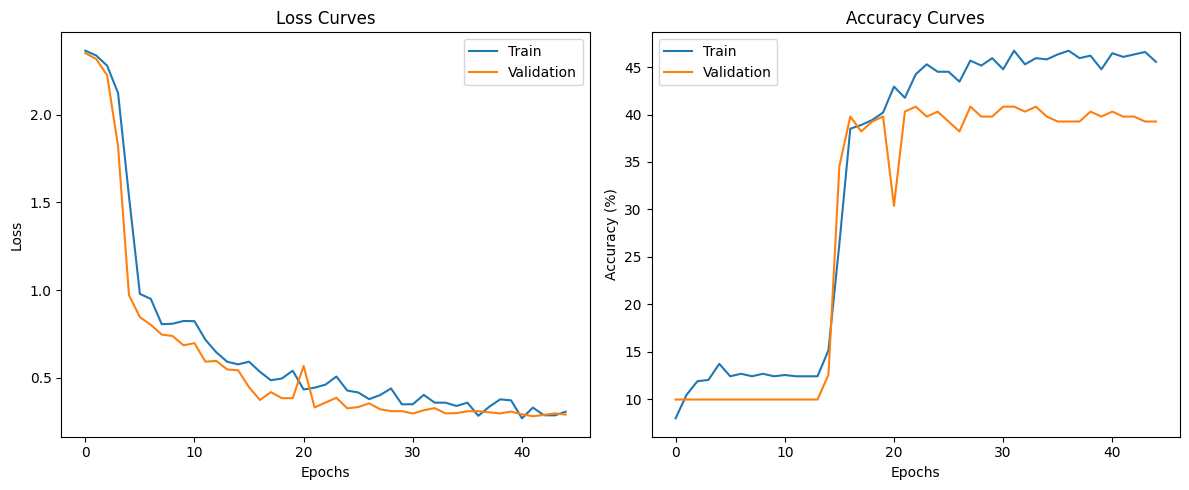

In [11]:
padwork_model = train_with_padwork_data()


In [19]:
fight_data = process_coco_fight_data()

Initializing PoseDetector on device: cuda:0
Using model: yolov8x-pose.pt, conf_thresh: 0.25, kpt_thr: 0.2
Loading YOLOv8 pose model: yolov8x-pose.pt
GPU: NVIDIA A100-SXM4-40GB
CUDA is available: True
Initial GPU memory allocated: 0.073 GB
PoseDetector initialization complete
Processing task1: PXL_20250430_133109253.mp4
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Video info: 1920x1080, 59.998989186704435 fps, 13850 frames
Found 8 categories
Processing 1744 'jab' annotations
Processing 541 'cross' annotations
Processing 389 'hook' annotations
Processing 606 'uppercut' annotations
Processing 1582 'roundhouse' annotations
Processing 140 'teep' annotations
Processing 216 'knee' annotations
Processing 0 'elbow' annotations
Total annotations to process: 5218
Total unique frames to load: 5762
Processing annotation batch 1-512 of 5218
Preloading 628 frames for this batch
Batch processing 628 frames
Memory: 0.07GB used, 42.40GB free, batch: 512
Memory: 0.35

OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/RTM-FASS/data/fight_dataset/task1_roundhouse_5790_1.npy'

Using NVIDIA A100-SXM4-40GB with 42.47GB memory
Loaded padwork model - val_acc: 40.83769633507853%
Padwork classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'unknown', 'uppercut']
Fight classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'uppercut']
Combined classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'unknown', 'uppercut']
Loading padwork data from /content/drive/MyDrive/RTM-FASS/data/strike_dataset/metadata.json
Combined dataset: 11246 sequences
  - Padwork: 957
  - Fight: 10289
  - Fighter 0: 7682
  - Fighter 1: 3564
Class weights: {'cross': 0.9218032786885246, 'hook': 0.8758566978193146, 'jab': 0.5367506681939672, 'knee': 2.5057932263814617, 'roundhouse': 0.39102920723226703, 'teep': 5.2258364312267656, 'unknown': 702.875, 'uppercut': 1.313785046728972}
Could not compile model: Python 3.11+ not yet supported for torch.compile


Epoch 1/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/80:
  Training Loss: 2.8533, Acc: 27.69%
  Validation Loss: 2.3772, Acc: 25.24%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 0.00% (0/312)
    hook: 0.00% (0/304)
    jab: 0.00% (0/497)
    knee: 0.00% (0/121)
    roundhouse: 55.74% (413/741)
    teep: 0.00% (0/56)
    uppercut: 70.78% (155/219)
  Saved new best model: 25.24%


Epoch 2/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/80:
  Training Loss: 2.3675, Acc: 22.81%
  Validation Loss: 2.3037, Acc: 29.51%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 0.00% (0/312)
    hook: 0.00% (0/304)
    jab: 0.00% (0/497)
    knee: 0.00% (0/121)
    roundhouse: 75.84% (562/741)
    teep: 0.00% (0/56)
    uppercut: 46.58% (102/219)
  Saved new best model: 29.51%


Epoch 3/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/80:
  Training Loss: 2.3327, Acc: 27.98%
  Validation Loss: 2.2582, Acc: 28.71%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 0.00% (0/312)
    hook: 0.00% (0/304)
    jab: 0.00% (0/497)
    knee: 6.61% (8/121)
    roundhouse: 66.80% (495/741)
    teep: 0.00% (0/56)
    uppercut: 65.30% (143/219)


Epoch 4/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/80:
  Training Loss: 2.2893, Acc: 27.50%
  Validation Loss: 2.1703, Acc: 29.16%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 0.00% (0/312)
    hook: 0.00% (0/304)
    jab: 0.00% (0/497)
    knee: 21.49% (26/121)
    roundhouse: 61.54% (456/741)
    teep: 0.00% (0/56)
    uppercut: 79.45% (174/219)


Epoch 5/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/80:
  Training Loss: 2.2330, Acc: 26.17%
  Validation Loss: 2.0360, Acc: 29.82%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 4.17% (13/312)
    hook: 1.97% (6/304)
    jab: 0.00% (0/497)
    knee: 68.60% (83/121)
    roundhouse: 53.31% (395/741)
    teep: 0.00% (0/56)
    uppercut: 79.45% (174/219)
  Saved new best model: 29.82%


Epoch 6/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/80:
  Training Loss: 2.1331, Acc: 24.66%
  Validation Loss: 1.8976, Acc: 25.82%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 10.26% (32/312)
    hook: 10.20% (31/304)
    jab: 0.60% (3/497)
    knee: 75.21% (91/121)
    roundhouse: 28.74% (213/741)
    teep: 67.86% (38/56)
    uppercut: 79.00% (173/219)


Epoch 7/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/80:
  Training Loss: 2.0575, Acc: 25.19%
  Validation Loss: 1.8011, Acc: 25.47%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 30.45% (95/312)
    hook: 24.34% (74/304)
    jab: 3.62% (18/497)
    knee: 73.55% (89/121)
    roundhouse: 9.85% (73/741)
    teep: 82.14% (46/56)
    uppercut: 81.28% (178/219)


Epoch 8/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/80:
  Training Loss: 1.9765, Acc: 27.57%
  Validation Loss: 1.7322, Acc: 27.24%
  Learning rate: 0.000200
  Class-wise accuracy:
    cross: 41.67% (130/312)
    hook: 30.26% (92/304)
    jab: 4.83% (24/497)
    knee: 76.03% (92/121)
    roundhouse: 8.77% (65/741)
    teep: 82.14% (46/56)
    uppercut: 74.89% (164/219)


Epoch 9/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/80:
  Training Loss: 1.8782, Acc: 26.92%
  Validation Loss: 1.6782, Acc: 29.11%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 46.15% (144/312)
    hook: 28.62% (87/304)
    jab: 5.63% (28/497)
    knee: 75.21% (91/121)
    roundhouse: 10.66% (79/741)
    teep: 75.00% (42/56)
    uppercut: 84.02% (184/219)


Epoch 10/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/80:
  Training Loss: 1.9359, Acc: 28.99%
  Validation Loss: 1.6175, Acc: 31.42%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 53.85% (168/312)
    hook: 32.89% (100/304)
    jab: 12.68% (63/497)
    knee: 80.99% (98/121)
    roundhouse: 8.10% (60/741)
    teep: 76.79% (43/56)
    uppercut: 79.91% (175/219)
  Saved new best model: 31.42%


Epoch 11/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/80:
  Training Loss: 1.7977, Acc: 30.59%
  Validation Loss: 1.5623, Acc: 32.04%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 56.09% (175/312)
    hook: 36.84% (112/304)
    jab: 13.48% (67/497)
    knee: 83.47% (101/121)
    roundhouse: 7.15% (53/741)
    teep: 89.29% (50/56)
    uppercut: 74.43% (163/219)
  Saved new best model: 32.04%


Epoch 12/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/80:
  Training Loss: 1.7602, Acc: 32.10%
  Validation Loss: 1.5100, Acc: 33.60%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 58.33% (182/312)
    hook: 40.13% (122/304)
    jab: 13.48% (67/497)
    knee: 85.12% (103/121)
    roundhouse: 8.37% (62/741)
    teep: 92.86% (52/56)
    uppercut: 76.71% (168/219)
  Saved new best model: 33.60%


Epoch 13/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/80:
  Training Loss: 1.8337, Acc: 32.60%
  Validation Loss: 1.4953, Acc: 36.58%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 61.54% (192/312)
    hook: 52.63% (160/304)
    jab: 13.48% (67/497)
    knee: 82.64% (100/121)
    roundhouse: 11.88% (88/741)
    teep: 82.14% (46/56)
    uppercut: 77.63% (170/219)
  Saved new best model: 36.58%


Epoch 14/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/80:
  Training Loss: 1.6748, Acc: 35.10%
  Validation Loss: 1.4382, Acc: 38.04%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 59.94% (187/312)
    hook: 53.95% (164/304)
    jab: 15.29% (76/497)
    knee: 88.43% (107/121)
    roundhouse: 13.50% (100/741)
    teep: 85.71% (48/56)
    uppercut: 79.45% (174/219)
  Saved new best model: 38.04%


Epoch 15/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/80:
  Training Loss: 1.6518, Acc: 36.57%
  Validation Loss: 1.4090, Acc: 40.13%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 60.90% (190/312)
    hook: 62.50% (190/304)
    jab: 18.11% (90/497)
    knee: 83.47% (101/121)
    roundhouse: 13.90% (103/741)
    teep: 85.71% (48/56)
    uppercut: 82.65% (181/219)
  Saved new best model: 40.13%


Epoch 16/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/80:
  Training Loss: 1.6540, Acc: 38.69%
  Validation Loss: 1.3777, Acc: 42.27%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 65.71% (205/312)
    hook: 64.14% (195/304)
    jab: 22.13% (110/497)
    knee: 86.78% (105/121)
    roundhouse: 14.71% (109/741)
    teep: 83.93% (47/56)
    uppercut: 82.19% (180/219)
  Saved new best model: 42.27%


Epoch 17/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/80:
  Training Loss: 1.6091, Acc: 38.76%
  Validation Loss: 1.3376, Acc: 44.40%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 66.35% (207/312)
    hook: 55.92% (170/304)
    jab: 29.38% (146/497)
    knee: 85.95% (104/121)
    roundhouse: 21.05% (156/741)
    teep: 92.86% (52/56)
    uppercut: 74.89% (164/219)
  Saved new best model: 44.40%


Epoch 18/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/80:
  Training Loss: 1.5286, Acc: 41.82%
  Validation Loss: 1.2765, Acc: 44.89%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 64.42% (201/312)
    hook: 60.53% (184/304)
    jab: 27.57% (137/497)
    knee: 87.60% (106/121)
    roundhouse: 19.84% (147/741)
    teep: 92.86% (52/56)
    uppercut: 83.56% (183/219)
  Saved new best model: 44.89%


Epoch 19/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/80:
  Training Loss: 1.4868, Acc: 43.44%
  Validation Loss: 1.2526, Acc: 46.84%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 79.49% (248/312)
    hook: 59.21% (180/304)
    jab: 27.97% (139/497)
    knee: 88.43% (107/121)
    roundhouse: 21.32% (158/741)
    teep: 87.50% (49/56)
    uppercut: 79.00% (173/219)
  Saved new best model: 46.84%


Epoch 20/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/80:
  Training Loss: 1.4727, Acc: 46.28%
  Validation Loss: 1.2210, Acc: 50.31%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 79.49% (248/312)
    hook: 64.80% (197/304)
    jab: 31.99% (159/497)
    knee: 87.60% (106/121)
    roundhouse: 29.42% (218/741)
    teep: 92.86% (52/56)
    uppercut: 69.41% (152/219)
  Saved new best model: 50.31%


Epoch 21/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/80:
  Training Loss: 1.4337, Acc: 47.97%
  Validation Loss: 1.1968, Acc: 53.11%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 73.72% (230/312)
    hook: 63.82% (194/304)
    jab: 35.61% (177/497)
    knee: 88.43% (107/121)
    roundhouse: 34.68% (257/741)
    teep: 87.50% (49/56)
    uppercut: 82.65% (181/219)
  Saved new best model: 53.11%


Epoch 22/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/80:
  Training Loss: 1.4240, Acc: 50.24%
  Validation Loss: 1.1699, Acc: 57.87%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 80.45% (251/312)
    hook: 69.74% (212/304)
    jab: 41.25% (205/497)
    knee: 83.47% (101/121)
    roundhouse: 42.65% (316/741)
    teep: 83.93% (47/56)
    uppercut: 77.63% (170/219)
  Saved new best model: 57.87%


Epoch 23/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/80:
  Training Loss: 1.3568, Acc: 52.45%
  Validation Loss: 1.0895, Acc: 58.36%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 74.36% (232/312)
    hook: 66.12% (201/304)
    jab: 38.23% (190/497)
    knee: 89.26% (108/121)
    roundhouse: 46.69% (346/741)
    teep: 91.07% (51/56)
    uppercut: 84.47% (185/219)
  Saved new best model: 58.36%


Epoch 24/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/80:
  Training Loss: 1.3334, Acc: 54.50%
  Validation Loss: 1.0679, Acc: 62.18%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 75.96% (237/312)
    hook: 72.04% (219/304)
    jab: 47.28% (235/497)
    knee: 85.12% (103/121)
    roundhouse: 48.72% (361/741)
    teep: 92.86% (52/56)
    uppercut: 87.67% (192/219)
  Saved new best model: 62.18%


Epoch 25/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/80:
  Training Loss: 1.3329, Acc: 54.97%
  Validation Loss: 1.0367, Acc: 63.47%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 77.56% (242/312)
    hook: 64.47% (196/304)
    jab: 48.69% (242/497)
    knee: 87.60% (106/121)
    roundhouse: 56.14% (416/741)
    teep: 91.07% (51/56)
    uppercut: 79.91% (175/219)
  Saved new best model: 63.47%


Epoch 26/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/80:
  Training Loss: 1.2891, Acc: 56.64%
  Validation Loss: 1.0224, Acc: 65.47%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 81.09% (253/312)
    hook: 75.33% (229/304)
    jab: 43.66% (217/497)
    knee: 85.12% (103/121)
    roundhouse: 59.51% (441/741)
    teep: 80.36% (45/56)
    uppercut: 84.47% (185/219)
  Saved new best model: 65.47%


Epoch 27/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/80:
  Training Loss: 1.2489, Acc: 59.00%
  Validation Loss: 0.9905, Acc: 66.98%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 81.73% (255/312)
    hook: 74.34% (226/304)
    jab: 52.92% (263/497)
    knee: 85.95% (104/121)
    roundhouse: 58.03% (430/741)
    teep: 82.14% (46/56)
    uppercut: 83.56% (183/219)
  Saved new best model: 66.98%


Epoch 28/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/80:
  Training Loss: 1.2301, Acc: 61.09%
  Validation Loss: 0.9391, Acc: 69.02%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 81.73% (255/312)
    hook: 76.97% (234/304)
    jab: 48.69% (242/497)
    knee: 88.43% (107/121)
    roundhouse: 65.72% (487/741)
    teep: 87.50% (49/56)
    uppercut: 81.74% (179/219)
  Saved new best model: 69.02%


Epoch 29/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/80:
  Training Loss: 1.1830, Acc: 63.47%
  Validation Loss: 0.9387, Acc: 71.78%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 80.77% (252/312)
    hook: 75.00% (228/304)
    jab: 60.56% (301/497)
    knee: 89.26% (108/121)
    roundhouse: 66.53% (493/741)
    teep: 87.50% (49/56)
    uppercut: 84.02% (184/219)
  Saved new best model: 71.78%


Epoch 30/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/80:
  Training Loss: 1.1515, Acc: 64.18%
  Validation Loss: 0.8767, Acc: 69.51%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 82.05% (256/312)
    hook: 77.30% (235/304)
    jab: 56.54% (281/497)
    knee: 88.43% (107/121)
    roundhouse: 59.78% (443/741)
    teep: 92.86% (52/56)
    uppercut: 86.76% (190/219)


Epoch 31/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/80:
  Training Loss: 1.1450, Acc: 65.53%
  Validation Loss: 0.8609, Acc: 73.16%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 84.62% (264/312)
    hook: 72.04% (219/304)
    jab: 61.37% (305/497)
    knee: 88.43% (107/121)
    roundhouse: 69.10% (512/741)
    teep: 91.07% (51/56)
    uppercut: 85.84% (188/219)
  Saved new best model: 73.16%


Epoch 32/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/80:
  Training Loss: 1.1449, Acc: 66.75%
  Validation Loss: 0.8764, Acc: 72.89%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 87.18% (272/312)
    hook: 76.32% (232/304)
    jab: 54.33% (270/497)
    knee: 84.30% (102/121)
    roundhouse: 71.93% (533/741)
    teep: 78.57% (44/56)
    uppercut: 85.39% (187/219)


Epoch 33/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/80:
  Training Loss: 1.0891, Acc: 68.34%
  Validation Loss: 0.8351, Acc: 72.27%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 87.50% (273/312)
    hook: 79.61% (242/304)
    jab: 59.76% (297/497)
    knee: 85.12% (103/121)
    roundhouse: 63.83% (473/741)
    teep: 89.29% (50/56)
    uppercut: 85.84% (188/219)


Epoch 34/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/80:
  Training Loss: 1.0576, Acc: 69.59%
  Validation Loss: 0.7885, Acc: 77.56%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 82.37% (257/312)
    hook: 76.64% (233/304)
    jab: 69.42% (345/497)
    knee: 86.78% (105/121)
    roundhouse: 77.19% (572/741)
    teep: 85.71% (48/56)
    uppercut: 84.47% (185/219)
  Saved new best model: 77.56%


Epoch 35/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/80:
  Training Loss: 1.0366, Acc: 70.26%
  Validation Loss: 0.7853, Acc: 76.84%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 78.53% (245/312)
    hook: 83.22% (253/304)
    jab: 63.78% (317/497)
    knee: 87.60% (106/121)
    roundhouse: 76.25% (565/741)
    teep: 91.07% (51/56)
    uppercut: 87.67% (192/219)


Epoch 36/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/80:
  Training Loss: 0.9937, Acc: 71.65%
  Validation Loss: 0.7709, Acc: 75.51%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 85.90% (268/312)
    hook: 82.57% (251/304)
    jab: 58.35% (290/497)
    knee: 87.60% (106/121)
    roundhouse: 73.14% (542/741)
    teep: 87.50% (49/56)
    uppercut: 88.13% (193/219)


Epoch 37/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/80:
  Training Loss: 0.9793, Acc: 73.04%
  Validation Loss: 0.7766, Acc: 78.58%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 86.22% (269/312)
    hook: 78.95% (240/304)
    jab: 71.03% (353/497)
    knee: 89.26% (108/121)
    roundhouse: 75.98% (563/741)
    teep: 75.00% (42/56)
    uppercut: 88.13% (193/219)
  Saved new best model: 78.58%


Epoch 38/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/80:
  Training Loss: 0.9766, Acc: 73.52%
  Validation Loss: 0.7572, Acc: 78.44%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 87.50% (273/312)
    hook: 75.00% (228/304)
    jab: 66.80% (332/497)
    knee: 89.26% (108/121)
    roundhouse: 79.76% (591/741)
    teep: 89.29% (50/56)
    uppercut: 83.56% (183/219)


Epoch 39/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/80:
  Training Loss: 0.9333, Acc: 74.74%
  Validation Loss: 0.7311, Acc: 80.22%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 88.46% (276/312)
    hook: 85.86% (261/304)
    jab: 69.01% (343/497)
    knee: 87.60% (106/121)
    roundhouse: 78.41% (581/741)
    teep: 85.71% (48/56)
    uppercut: 86.76% (190/219)
  Saved new best model: 80.22%


Epoch 40/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/80:
  Training Loss: 0.9292, Acc: 75.78%
  Validation Loss: 0.6935, Acc: 79.11%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 85.90% (268/312)
    hook: 83.55% (254/304)
    jab: 74.25% (369/497)
    knee: 85.95% (104/121)
    roundhouse: 73.41% (544/741)
    teep: 89.29% (50/56)
    uppercut: 87.21% (191/219)


Epoch 41/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/80:
  Training Loss: 0.8906, Acc: 76.62%
  Validation Loss: 0.6657, Acc: 82.98%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 86.22% (269/312)
    hook: 81.91% (249/304)
    jab: 83.10% (413/497)
    knee: 87.60% (106/121)
    roundhouse: 79.22% (587/741)
    teep: 89.29% (50/56)
    uppercut: 88.13% (193/219)
  Saved new best model: 82.98%


Epoch 42/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/80:
  Training Loss: 0.8718, Acc: 77.06%
  Validation Loss: 0.6746, Acc: 79.56%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 79.81% (249/312)
    hook: 84.54% (257/304)
    jab: 67.40% (335/497)
    knee: 87.60% (106/121)
    roundhouse: 80.03% (593/741)
    teep: 92.86% (52/56)
    uppercut: 90.41% (198/219)


Epoch 43/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/80:
  Training Loss: 0.8752, Acc: 76.96%
  Validation Loss: 0.6683, Acc: 79.24%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 89.42% (279/312)
    hook: 81.58% (248/304)
    jab: 68.21% (339/497)
    knee: 89.26% (108/121)
    roundhouse: 75.17% (557/741)
    teep: 91.07% (51/56)
    uppercut: 91.78% (201/219)


Epoch 44/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/80:
  Training Loss: 0.8724, Acc: 78.05%
  Validation Loss: 0.6290, Acc: 84.40%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 85.58% (267/312)
    hook: 88.49% (269/304)
    jab: 80.48% (400/497)
    knee: 88.43% (107/121)
    roundhouse: 83.00% (615/741)
    teep: 83.93% (47/56)
    uppercut: 88.58% (194/219)
  Saved new best model: 84.40%


Epoch 45/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/80:
  Training Loss: 0.8568, Acc: 78.55%
  Validation Loss: 0.6144, Acc: 83.47%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 90.06% (281/312)
    hook: 88.49% (269/304)
    jab: 75.05% (373/497)
    knee: 90.08% (109/121)
    roundhouse: 81.92% (607/741)
    teep: 91.07% (51/56)
    uppercut: 85.84% (188/219)


Epoch 46/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/80:
  Training Loss: 0.8154, Acc: 79.88%
  Validation Loss: 0.6158, Acc: 83.60%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 83.01% (259/312)
    hook: 84.87% (258/304)
    jab: 77.87% (387/497)
    knee: 88.43% (107/121)
    roundhouse: 84.08% (623/741)
    teep: 91.07% (51/56)
    uppercut: 89.50% (196/219)


Epoch 47/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/80:
  Training Loss: 0.7893, Acc: 80.58%
  Validation Loss: 0.6066, Acc: 85.02%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 89.10% (278/312)
    hook: 87.50% (266/304)
    jab: 82.29% (409/497)
    knee: 86.78% (105/121)
    roundhouse: 83.27% (617/741)
    teep: 83.93% (47/56)
    uppercut: 87.21% (191/219)
  Saved new best model: 85.02%


Epoch 48/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/80:
  Training Loss: 0.7719, Acc: 80.77%
  Validation Loss: 0.5710, Acc: 86.84%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 90.06% (281/312)
    hook: 88.82% (270/304)
    jab: 83.50% (415/497)
    knee: 88.43% (107/121)
    roundhouse: 86.50% (641/741)
    teep: 85.71% (48/56)
    uppercut: 87.67% (192/219)
  Saved new best model: 86.84%


Epoch 49/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/80:
  Training Loss: 0.7818, Acc: 82.06%
  Validation Loss: 0.5816, Acc: 85.11%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 90.06% (281/312)
    hook: 85.53% (260/304)
    jab: 79.28% (394/497)
    knee: 90.08% (109/121)
    roundhouse: 83.94% (622/741)
    teep: 89.29% (50/56)
    uppercut: 90.87% (199/219)


Epoch 50/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/80:
  Training Loss: 0.7555, Acc: 82.76%
  Validation Loss: 0.5759, Acc: 84.76%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 90.38% (282/312)
    hook: 83.55% (254/304)
    jab: 80.89% (402/497)
    knee: 85.12% (103/121)
    roundhouse: 83.40% (618/741)
    teep: 91.07% (51/56)
    uppercut: 89.95% (197/219)


Epoch 51/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/80:
  Training Loss: 0.7418, Acc: 82.64%
  Validation Loss: 0.5243, Acc: 87.38%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 90.06% (281/312)
    hook: 86.84% (264/304)
    jab: 86.92% (432/497)
    knee: 89.26% (108/121)
    roundhouse: 85.83% (636/741)
    teep: 87.50% (49/56)
    uppercut: 89.50% (196/219)
  Saved new best model: 87.38%


Epoch 52/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/80:
  Training Loss: 0.7367, Acc: 83.59%
  Validation Loss: 0.5648, Acc: 84.98%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.31% (288/312)
    hook: 86.84% (264/304)
    jab: 82.29% (409/497)
    knee: 91.74% (111/121)
    roundhouse: 80.03% (593/741)
    teep: 87.50% (49/56)
    uppercut: 90.41% (198/219)


Epoch 53/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/80:
  Training Loss: 0.7031, Acc: 83.47%
  Validation Loss: 0.5286, Acc: 86.40%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 88.14% (275/312)
    hook: 84.87% (258/304)
    jab: 85.71% (426/497)
    knee: 90.08% (109/121)
    roundhouse: 83.67% (620/741)
    teep: 91.07% (51/56)
    uppercut: 93.61% (205/219)


Epoch 54/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/80:
  Training Loss: 0.6935, Acc: 84.28%
  Validation Loss: 0.5129, Acc: 86.71%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.91% (293/312)
    hook: 82.24% (250/304)
    jab: 87.53% (435/497)
    knee: 92.56% (112/121)
    roundhouse: 81.51% (604/741)
    teep: 91.07% (51/56)
    uppercut: 94.06% (206/219)


Epoch 55/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/80:
  Training Loss: 0.6861, Acc: 84.18%
  Validation Loss: 0.5208, Acc: 87.69%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.91% (293/312)
    hook: 86.51% (263/304)
    jab: 85.31% (424/497)
    knee: 88.43% (107/121)
    roundhouse: 86.91% (644/741)
    teep: 85.71% (48/56)
    uppercut: 88.58% (194/219)
  Saved new best model: 87.69%


Epoch 56/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/80:
  Training Loss: 0.6846, Acc: 84.36%
  Validation Loss: 0.5028, Acc: 88.13%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 91.03% (284/312)
    hook: 83.22% (253/304)
    jab: 89.74% (446/497)
    knee: 91.74% (111/121)
    roundhouse: 85.96% (637/741)
    teep: 89.29% (50/56)
    uppercut: 92.24% (202/219)
  Saved new best model: 88.13%


Epoch 57/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/80:
  Training Loss: 0.6398, Acc: 85.40%
  Validation Loss: 0.4771, Acc: 88.76%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 88.46% (276/312)
    hook: 87.17% (265/304)
    jab: 87.12% (433/497)
    knee: 88.43% (107/121)
    roundhouse: 89.47% (663/741)
    teep: 85.71% (48/56)
    uppercut: 93.61% (205/219)
  Saved new best model: 88.76%


Epoch 58/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/80:
  Training Loss: 0.6209, Acc: 85.87%
  Validation Loss: 0.4695, Acc: 88.36%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.31% (288/312)
    hook: 88.16% (268/304)
    jab: 84.31% (419/497)
    knee: 88.43% (107/121)
    roundhouse: 88.39% (655/741)
    teep: 89.29% (50/56)
    uppercut: 91.78% (201/219)


Epoch 59/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/80:
  Training Loss: 0.6542, Acc: 85.58%
  Validation Loss: 0.4588, Acc: 89.24%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.91% (293/312)
    hook: 88.16% (268/304)
    jab: 86.72% (431/497)
    knee: 90.91% (110/121)
    roundhouse: 88.26% (654/741)
    teep: 91.07% (51/56)
    uppercut: 91.78% (201/219)
  Saved new best model: 89.24%


Epoch 60/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/80:
  Training Loss: 0.5873, Acc: 86.16%
  Validation Loss: 0.5013, Acc: 86.62%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 89.10% (278/312)
    hook: 87.17% (265/304)
    jab: 89.13% (443/497)
    knee: 88.43% (107/121)
    roundhouse: 81.11% (601/741)
    teep: 91.07% (51/56)
    uppercut: 93.15% (204/219)


Epoch 61/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/80:
  Training Loss: 0.5977, Acc: 86.66%
  Validation Loss: 0.4709, Acc: 88.58%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.27% (291/312)
    hook: 86.51% (263/304)
    jab: 89.94% (447/497)
    knee: 90.91% (110/121)
    roundhouse: 84.75% (628/741)
    teep: 91.07% (51/56)
    uppercut: 92.69% (203/219)


Epoch 62/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/80:
  Training Loss: 0.6048, Acc: 86.41%
  Validation Loss: 0.4804, Acc: 88.04%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 89.74% (280/312)
    hook: 89.14% (271/304)
    jab: 83.10% (413/497)
    knee: 88.43% (107/121)
    roundhouse: 90.15% (668/741)
    teep: 92.86% (52/56)
    uppercut: 86.76% (190/219)


Epoch 63/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/80:
  Training Loss: 0.5805, Acc: 87.06%
  Validation Loss: 0.4343, Acc: 89.73%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.95% (290/312)
    hook: 90.79% (276/304)
    jab: 88.13% (438/497)
    knee: 90.08% (109/121)
    roundhouse: 87.31% (647/741)
    teep: 92.86% (52/56)
    uppercut: 94.52% (207/219)
  Saved new best model: 89.73%


Epoch 64/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/80:
  Training Loss: 0.5798, Acc: 87.24%
  Validation Loss: 0.4688, Acc: 89.82%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.31% (288/312)
    hook: 90.46% (275/304)
    jab: 87.53% (435/497)
    knee: 89.26% (108/121)
    roundhouse: 89.61% (664/741)
    teep: 91.07% (51/56)
    uppercut: 91.32% (200/219)
  Saved new best model: 89.82%


Epoch 65/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/80:
  Training Loss: 0.5784, Acc: 87.94%
  Validation Loss: 0.4898, Acc: 90.00%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.63% (289/312)
    hook: 86.51% (263/304)
    jab: 88.73% (441/497)
    knee: 89.26% (108/121)
    roundhouse: 91.36% (677/741)
    teep: 82.14% (46/56)
    uppercut: 91.78% (201/219)
  Saved new best model: 90.00%


Epoch 66/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/80:
  Training Loss: 0.5522, Acc: 88.14%
  Validation Loss: 0.4049, Acc: 90.27%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.31% (288/312)
    hook: 85.53% (260/304)
    jab: 88.13% (438/497)
    knee: 90.91% (110/121)
    roundhouse: 91.36% (677/741)
    teep: 92.86% (52/56)
    uppercut: 94.06% (206/219)
  Saved new best model: 90.27%


Epoch 67/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/80:
  Training Loss: 0.5724, Acc: 88.31%
  Validation Loss: 0.4199, Acc: 90.84%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.63% (289/312)
    hook: 90.46% (275/304)
    jab: 89.94% (447/497)
    knee: 91.74% (111/121)
    roundhouse: 90.96% (674/741)
    teep: 87.50% (49/56)
    uppercut: 90.87% (199/219)
  Saved new best model: 90.84%


Epoch 68/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/80:
  Training Loss: 0.5271, Acc: 88.38%
  Validation Loss: 0.3891, Acc: 91.69%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.91% (293/312)
    hook: 92.43% (281/304)
    jab: 89.13% (443/497)
    knee: 90.08% (109/121)
    roundhouse: 92.44% (685/741)
    teep: 91.07% (51/56)
    uppercut: 91.78% (201/219)
  Saved new best model: 91.69%


Epoch 69/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/80:
  Training Loss: 0.5317, Acc: 88.97%
  Validation Loss: 0.4028, Acc: 90.58%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 92.31% (288/312)
    hook: 90.79% (276/304)
    jab: 86.12% (428/497)
    knee: 90.08% (109/121)
    roundhouse: 91.77% (680/741)
    teep: 91.07% (51/56)
    uppercut: 94.06% (206/219)


Epoch 70/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/80:
  Training Loss: 0.5270, Acc: 88.17%
  Validation Loss: 0.4373, Acc: 89.33%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 87.82% (274/312)
    hook: 90.79% (276/304)
    jab: 90.14% (448/497)
    knee: 91.74% (111/121)
    roundhouse: 87.58% (649/741)
    teep: 91.07% (51/56)
    uppercut: 91.78% (201/219)


Epoch 71/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/80:
  Training Loss: 0.4995, Acc: 88.73%
  Validation Loss: 0.3924, Acc: 92.13%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 94.23% (294/312)
    hook: 87.83% (267/304)
    jab: 92.15% (458/497)
    knee: 89.26% (108/121)
    roundhouse: 93.25% (691/741)
    teep: 89.29% (50/56)
    uppercut: 93.61% (205/219)
  Saved new best model: 92.13%


Epoch 72/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/80:
  Training Loss: 0.4917, Acc: 89.28%
  Validation Loss: 0.4383, Acc: 87.96%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 93.27% (291/312)
    hook: 89.47% (272/304)
    jab: 83.50% (415/497)
    knee: 92.56% (112/121)
    roundhouse: 85.16% (631/741)
    teep: 92.86% (52/56)
    uppercut: 94.06% (206/219)


Epoch 73/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/80:
  Training Loss: 0.5083, Acc: 89.11%
  Validation Loss: 0.4000, Acc: 90.62%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 91.35% (285/312)
    hook: 89.80% (273/304)
    jab: 91.95% (457/497)
    knee: 90.08% (109/121)
    roundhouse: 88.26% (654/741)
    teep: 91.07% (51/56)
    uppercut: 95.89% (210/219)


Epoch 74/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/80:
  Training Loss: 0.4734, Acc: 89.83%
  Validation Loss: 0.3835, Acc: 91.82%
  Learning rate: 0.000100
  Class-wise accuracy:
    cross: 91.03% (284/312)
    hook: 89.47% (272/304)
    jab: 91.75% (456/497)
    knee: 90.91% (110/121)
    roundhouse: 93.93% (696/741)
    teep: 89.29% (50/56)
    uppercut: 90.41% (198/219)


Epoch 75/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00075: reducing learning rate of group 0 to 5.0000e-05.
Epoch 75/80:
  Training Loss: 0.4581, Acc: 90.12%
  Validation Loss: 0.3654, Acc: 91.69%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 88.78% (277/312)
    hook: 93.42% (284/304)
    jab: 90.14% (448/497)
    knee: 92.56% (112/121)
    roundhouse: 91.77% (680/741)
    teep: 92.86% (52/56)
    uppercut: 95.89% (210/219)


Epoch 76/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/80:
  Training Loss: 0.4515, Acc: 90.96%
  Validation Loss: 0.3750, Acc: 92.84%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 91.99% (287/312)
    hook: 92.76% (282/304)
    jab: 90.95% (452/497)
    knee: 93.39% (113/121)
    roundhouse: 94.20% (698/741)
    teep: 83.93% (47/56)
    uppercut: 95.89% (210/219)
  Saved new best model: 92.84%


Epoch 77/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/80:
  Training Loss: 0.4620, Acc: 90.97%
  Validation Loss: 0.3522, Acc: 92.80%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 94.55% (295/312)
    hook: 90.46% (275/304)
    jab: 92.76% (461/497)
    knee: 90.08% (109/121)
    roundhouse: 93.39% (692/741)
    teep: 89.29% (50/56)
    uppercut: 94.06% (206/219)


Epoch 78/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/80:
  Training Loss: 0.4246, Acc: 91.15%
  Validation Loss: 0.3606, Acc: 92.62%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 92.63% (289/312)
    hook: 90.79% (276/304)
    jab: 93.16% (463/497)
    knee: 91.74% (111/121)
    roundhouse: 92.71% (687/741)
    teep: 91.07% (51/56)
    uppercut: 94.52% (207/219)


Epoch 79/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/80:
  Training Loss: 0.4146, Acc: 90.76%
  Validation Loss: 0.3448, Acc: 93.56%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 89.10% (278/312)
    hook: 92.11% (280/304)
    jab: 94.16% (468/497)
    knee: 93.39% (113/121)
    roundhouse: 95.68% (709/741)
    teep: 91.07% (51/56)
    uppercut: 94.06% (206/219)
  Saved new best model: 93.56%


Epoch 80/80 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80/80 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/80:
  Training Loss: 0.4219, Acc: 91.54%
  Validation Loss: 0.3330, Acc: 94.18%
  Learning rate: 0.000050
  Class-wise accuracy:
    cross: 94.23% (294/312)
    hook: 91.78% (279/304)
    jab: 94.37% (469/497)
    knee: 91.74% (111/121)
    roundhouse: 95.55% (708/741)
    teep: 89.29% (50/56)
    uppercut: 94.98% (208/219)
  Saved new best model: 94.18%
Saved final model to /content/drive/MyDrive/RTM-FASS/models/FINAL_MODEL.pth
Training completed in 1.70 minutes
Best validation accuracy: 94.18%


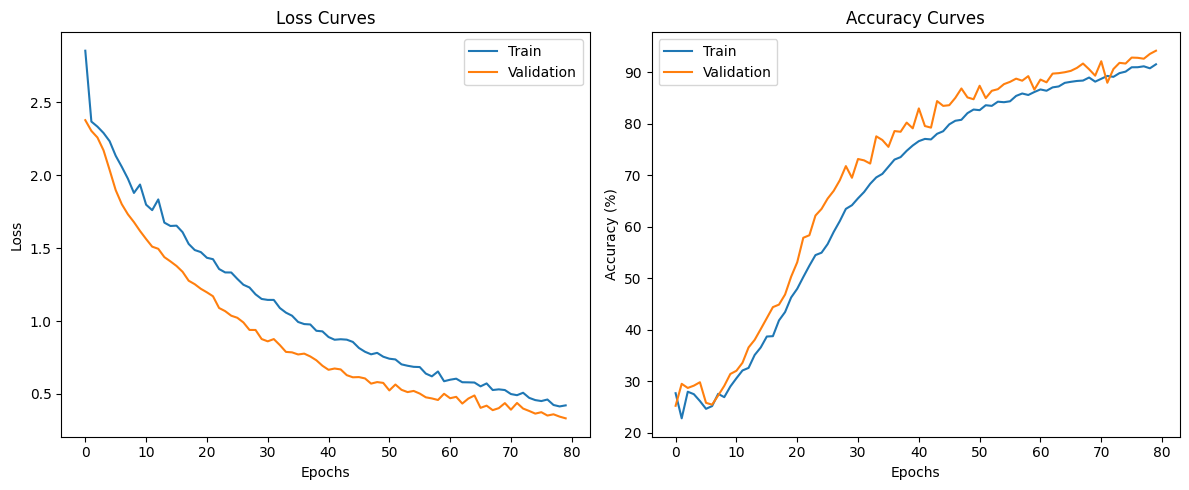

In [20]:
padwork_model = "/content/drive/MyDrive/RTM-FASS/models/best_model.pth"
fight_data = "/content/drive/MyDrive/RTM-FASS/data/fight_dataset/fighter_id_metadata.json"

combined_model = train_combined_model(padwork_model, fight_data)

# IF YOU WOULD JUST LIKE YOUR FIGHT ANALYSED, MAKE SURE TO RUN COMBINED MODEL FIRST

In [21]:
test_output = run_combined_model(combined_model)

Using device: cuda:0
Please upload a video file to analyze:


Saving test_video.mp4 to test_video.mp4
Uploaded test_video.mp4 (119.34 MB)
Loading model from /content/drive/MyDrive/RTM-FASS/models/FINAL_MODEL.pth...
Model loaded. Classes: ['cross', 'hook', 'jab', 'knee', 'roundhouse', 'teep', 'unknown', 'uppercut']
Validation accuracy: 94.17777777777778%
Initializing PoseDetector on device: cuda:0
Using model: yolov8x-pose.pt, conf_thresh: 0.3, kpt_thr: 0.2
Loading YOLOv8 pose model: yolov8x-pose.pt
GPU: NVIDIA A100-SXM4-40GB
CUDA is available: True
Initial GPU memory allocated: 0.400 GB
PoseDetector initialization complete
Processing video with 2911 frames...


  0%|          | 0/2911 [00:00<?, ?it/s]

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.6s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect




Analysis complete!
Output video saved to: /content/drive/MyDrive/RTM-FASS/outputs/analyzed_uploaded_test_video.mp4
Summary image saved to: /content/drive/MyDrive/RTM-FASS/outputs/summary_uploaded_test_video.jpg
Statistics saved to: /content/drive/MyDrive/RTM-FASS/outputs/stats_uploaded_test_video.json

=== STRIKE STATISTICS ===

Fighter 0:
Strike Type     Hits   Misses   Total  Accuracy
--------------------------------------------------
cross           29     5        34     85.3%
hook            5      0        5      100.0%
jab             12     5        17     70.6%
knee            4      4        8      50.0%
roundhouse      14     2        16     87.5%
uppercut        4      3        7      57.1%
--------------------------------------------------
TOTAL           68     19       87     78.2%

Fighter 1:
Strike Type     Hits   Misses   Total  Accuracy
--------------------------------------------------
cross           6      1        7      85.7%
hook            8      2        10 

In [ ]:
from IPython.display import HTML

if 'test_video' in results and results['test_video'] and os.path.exists(results['test_video']):
    video_html = f"""
    <video width="640" height="480" controls>
        <source src="{results['test_video']}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    display(HTML(video_html))

    # displays the summary image
    summary_image = results['test_video'].replace('.mp4', '_summary.jpg')
    if os.path.exists(summary_image):
        from IPython.display import Image
        display(Image(filename=summary_image))
else:
    print("No output video available")